# OSKM Per State per Day

Make a matrix of day x state with expression of OSKM (endo/exo both).

Inputs:
1. RNA Seurat object
2. Configs
3. RNA -> ATAC labels
4. Endogenous/Exogenous quantifications

In [160]:
library(ggplot2)
library(Seurat)
library(scales)
library(dplyr)
library(patchwork)

In [33]:
DAYS = c("D0", "D2" , "D4", "D6", "D8", "D10", "D12", "D14", "iPSC")

### Seurat Object

In [3]:
rna = readRDS("../../analysis/20200828_RNA_Seurat/sessions/20210725_n59378/seurat.rds")

### Configs

In [4]:
cluster_config = read.table("../configs/cluster.tsv", comment.char = '', header=T, sep='\t')
cluster_config$colour = as.character(cluster_config$colour)
cluster_config$description = as.character(cluster_config$description)

cluster_config

cluster,colour,description,new_cluster
<int>,<chr>,<chr>,<int>
1,#B03743,Fibroblast,1
2,#E85F6D,Fibroblast-like,3
3,#7C2730,Fibroblast-like,2
4,#F0A118,Intermediate,12
5,#78A824,Pre-iPSC,13
6,#A6D854,Pre-iPSC,14
7,#F01D35,Fibroblast-like,5
8,#13C4A3,iPSC,15
9,#406614,Partially-reprogrammed,10


### ATAC-RNA Cluster Transfer

In [5]:
atac.rna.label = read.table("../../analysis/20200828_RNA_Seurat/sessions/20210725_n59378/atac.20210717_n62599.cluster.transfer.tsv",
                           header=T)
rownames(atac.rna.label) = atac.rna.label$barcode
atac.rna.label$barcode = NULL

all(rownames(atac.rna.label)==colnames(rna))

# transfer to new cluster
atac.rna.label$atac_new_cluster = cluster_config[atac.rna.label$atac_cluster, "new_cluster"]

head(atac.rna.label)

[1] TRUE

,sample,atac_cluster,atac_new_cluster
,<fct>,<int>,<int>
AAACCCAAGAGTGACC-1,D0,1,1
AAACCCAAGTGCCAGA-1,D0,1,1
AAACCCACACCATTCC-1,D0,1,1
AAACCCACACGCGTCA-1,D0,1,1
AAACCCAGTCCATAGT-1,D0,1,1
AAACCCAGTTATTCTC-1,D0,1,1


### Endogenous/Exogenous Quantifications

In [110]:
endo_exo_expr = read.table("../../analysis/20211106_sendai_vs_endogenous/out/quants.tsv")
head(endo_exo_expr)

,POU5F1_endo_cts,POU5F1_endo_norm,POU5F1_exo_cts,POU5F1_exo_norm,SOX2_endo_cts,SOX2_endo_norm,SOX2_exo_cts,SOX2_exo_norm,KLF4_endo_cts,KLF4_endo_norm,KLF4_exo_cts,KLF4_exo_norm,MYC_endo_cts,MYC_endo_norm,MYC_exo_cts,MYC_exo_norm
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
AAACCCAAGAGTGACC-1,0,0,0,0,0,0,0,0,1,0.5478637,1.437999e-23,1.049098e-23,0,0.0000000,0.000000e+00,0.000000e+00
AAACCCAAGTGCCAGA-1,0,0,0,0,0,0,0,0,0,0.0000000,0.000000e+00,0.000000e+00,2,0.9641610,7.320248e-17,5.938868e-17
AAACCCACACCATTCC-1,0,0,0,0,0,0,0,0,1,0.5261623,1.507851e-17,1.044074e-17,1,0.5261623,8.043161e-15,5.569285e-15
AAACCCACACGCGTCA-1,0,0,0,0,0,0,0,0,1,0.7583202,1.472511e-20,1.670839e-20,0,0.0000000,0.000000e+00,0.000000e+00
AAACCCAGTCCATAGT-1,0,0,0,0,0,0,0,0,0,0.0000000,0.000000e+00,0.000000e+00,0,0.0000000,0.000000e+00,0.000000e+00
AAACCCAGTTATTCTC-1,0,0,0,0,0,0,0,0,0,0.0000000,0.000000e+00,0.000000e+00,1,0.5299292,2.326522e-13,1.625801e-13


## Plotting

In [6]:
all(colnames(rna) == rownames(atac.rna.label))

[1] TRUE

In [111]:
all(colnames(rna) == rownames(endo_exo_expr))

[1] TRUE

In [149]:
OSKM = c("POU5F1", "SOX2", "KLF4", "MYC")
expr = data.frame(t(as.matrix(rna@assays$RNA@data[OSKM, ])))
colnames(expr) = OSKM
expr$day = as.vector(unlist(rna$sample))
expr$cluster = as.vector(unlist(atac.rna.label$atac_new_cluster))
head(expr)

,POU5F1,SOX2,KLF4,MYC,day,cluster
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<int>
AAACCCAAGAGTGACC-1,0,0,0.5478637,0.0000000,D0,1
AAACCCAAGTGCCAGA-1,0,0,0.0000000,0.9641610,D0,1
AAACCCACACCATTCC-1,0,0,0.5261623,0.5261623,D0,1
AAACCCACACGCGTCA-1,0,0,0.7583202,0.0000000,D0,1
AAACCCAGTCCATAGT-1,0,0,0.0000000,0.0000000,D0,1
AAACCCAGTTATTCTC-1,0,0,0.0000000,0.5299292,D0,1


In [150]:
expr$endo_POU5F1 = endo_exo_expr$POU5F1_endo_norm
expr$endo_SOX2 = endo_exo_expr$SOX2_endo_norm
expr$endo_KLF4 = endo_exo_expr$KLF4_endo_norm
expr$endo_MYC = endo_exo_expr$MYC_endo_norm

In [151]:
day_cluster_cts = data.frame(expr %>% count(day,cluster))
rownames(day_cluster_cts) = paste(day_cluster_cts$day, day_cluster_cts$cluster, sep='_')
head(day_cluster_cts)

,day,cluster,n
,<chr>,<int>,<int>
D0_1,D0,1,9749
D0_2,D0,2,10
D10_3,D10,3,2919
D10_4,D10,4,1870
D10_5,D10,5,448
D10_9,D10,9,154


In [152]:
median_expr_day_cluster = data.frame(expr %>% group_by(day,cluster) %>%  summarise_all(median))
rownames(median_expr_day_cluster) = paste(median_expr_day_cluster$day, median_expr_day_cluster$cluster, sep='_')
median_expr_day_cluster$count = day_cluster_cts$n
head(median_expr_day_cluster)

,day,cluster,POU5F1,SOX2,KLF4,MYC,endo_POU5F1,endo_SOX2,endo_KLF4,endo_MYC,count
,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
D0_1,D0,1,0.0000000,0.0000000,0.0000000,0.000000,0.000000e+00,0.000000e+00,0,0.000000e+00,9749
D0_2,D0,2,0.0000000,0.0000000,0.0000000,0.000000,0.000000e+00,0.000000e+00,0,0.000000e+00,10
D10_3,D10,3,0.3817133,0.0000000,0.0000000,1.777681,0.000000e+00,0.000000e+00,0,3.201530e-14,2919
D10_4,D10,4,0.0000000,0.0000000,0.0000000,0.000000,0.000000e+00,0.000000e+00,0,0.000000e+00,1870
D10_5,D10,5,0.0000000,0.0000000,0.0000000,0.000000,0.000000e+00,0.000000e+00,0,0.000000e+00,448
D10_9,D10,9,1.3976705,0.5706953,0.4923391,1.828533,2.013561e-12,2.885019e-10,0,6.663942e-14,154


In [153]:
sort(median_expr_day_cluster$count)

[1]    6    7    7    9   10   25   58   64   76  103  121  133  154  210  227
[16]  296  310  340  375  448  559  564  576  600  689  767  906  933 1089 1127
[31] 1247 1318 1341 1447 1532 1829 1870 1871 2027 2224 2256 2574 2919 3125 3157
[46] 3577 4526 9749

In [154]:
# filter
median_expr_day_cluster = median_expr_day_cluster[median_expr_day_cluster$count > 50, ]

In [174]:
plot_endo_exo <- function(df, total_col, endo_col, title) {
    cur_df = df
    cur_df$log_total = cur_df[, total_col] # endo + exo
    cur_df$endo = round(100*(exp(cur_df[,endo_col]) - 1))
    cur_df$exo = round(100*(exp(cur_df$log_total) - exp(cur_df[,endo_col])))
    
    p <- ggplot(cur_df) + 
        geom_tile(aes(x=factor(day, levels=DAYS), y=factor(cluster), fill=log_total)) +
        geom_text(aes(x=factor(day, levels=DAYS), y=factor(cluster), label=paste(exo, endo, sep='/\n'), colour=log_total>2)) + 
        # geom_text(aes(x=Var2, y=Var1, label=rounded, colour=(rounded>2)), alpha=.7) +
        scale_colour_manual(values = c("white", "black")) +
        theme_bw(base_size=16) +
        ggtitle(title) + 
        # coord_fixed(clip="off") +
        xlab("Sample") + 
        ylab("Cluster") +
        scale_fill_viridis_c(option = "C", name="Log\nExpression") +
        guides(colour=FALSE) +
        theme(axis.ticks.x = element_line(colour = "black"),
             axis.text=element_text(size=12),
        #      axis.text.y = element_blank(),
             axis.title=element_text(size=15),
             legend.position="none",
             plot.title = element_text(hjust = 0.5))
    
    p
}

In [175]:
o = plot_endo_exo(median_expr_day_cluster, "POU5F1", "endo_POU5F1", "POU5F1")
s = plot_endo_exo(median_expr_day_cluster, "SOX2", "endo_SOX2", "SOX2")
k = plot_endo_exo(median_expr_day_cluster, "KLF4", "endo_KLF4", "KLF4")
m = plot_endo_exo(median_expr_day_cluster, "MYC", "endo_MYC", "MYC")

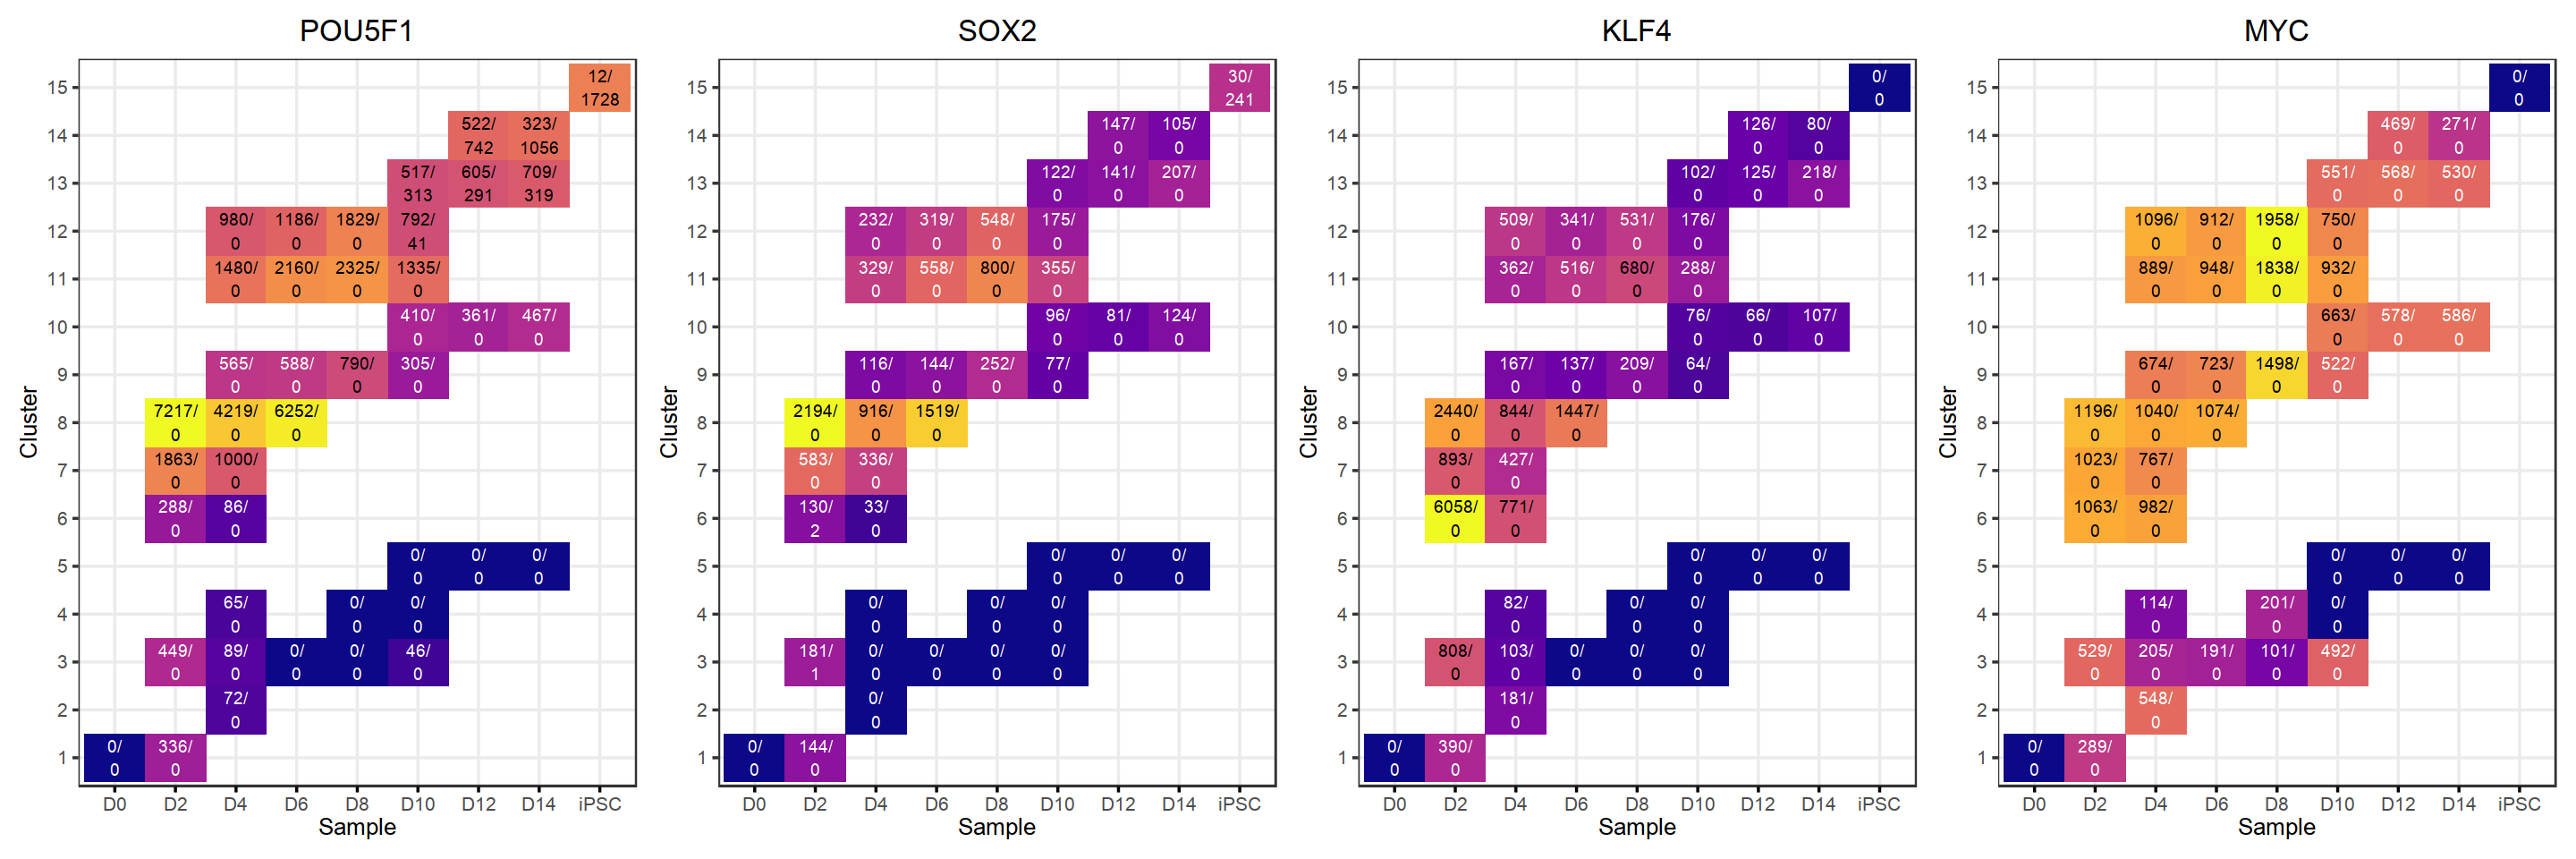

In [176]:
options(repr.plot.width = 24, repr.plot.height = 8)

p = o | s | k | m

p

In [178]:
ggsave(p, file="./subfigs/20211116_per_day_per_state_TPM.pdf", height=8, width=24, useDingbats=F)

---

In [177]:
sessionInfo()

R version 3.6.3 (2020-02-29)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: Ubuntu 18.04.5 LTS

Matrix products: default
BLAS/LAPACK: /users/surag/anaconda3/envs/r36_cran/lib/libopenblasp-r0.3.9.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] patchwork_1.0.0 dplyr_1.0.2     scales_1.1.0    Seurat_3.1.5   
[5] ggplot2_3.3.3  

loaded via a namespace (and not attached):
 [1] nlme_3.1-147        tsne_0.1-3          RcppAnnoy_0.0.16   
 [4] RColorBrewer_1.1-2  httr_1.4.1          repr_1.1.0         
 [7] sctransform_0.2.1   tools_3.6.3 